In [1]:
from space.planets import venus
from orbit.pointing import simulation
from orbit.geometry import getTiming
from orbit.envision import loadSV

""" System Packages """
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime as dt
import os

In [2]:
sim_folder = os.path.join(r"C:\Users",
                          r"ishuwa.sikaneta",
                          r"OneDrive - ESA",
                          r"Documents",
                          r"ESTEC",
                          r"Envision",
                          r"PointingSimulations")

### Load ESOC-supplied orbit file

In [3]:
sv = loadSV()

# Simulate Pointing Errors

The following class simulates pointing errors for an Envision-type SAR

In [4]:
eSim = simulation(planet = venus(),
                  e_ang = 14.28, # The effective angle of the beam relative to spacecraft coordinate frame
                  azAxis = 5.5,  # The length of the refelector in the azimuth direction. Leads to 0.99 degrees
                  elAxis = 0.6125,  # The length of the reflector in the elevation direction. Leads to 8.9 degrees
                  carrier = 3.15e9)

### Select a subset of state vectors

Select a range of state vectors to use for error simulation

In [5]:
selection_range = [270, 44480, 2]
mysvs = eSim.state(sv.measurementData, selection_range)
 
times = [(sv.measurementTime[k] - sv.measurementTime[0])/np.timedelta64(1, 's') 
         for k in range(*selection_range)]

### Test the simulation of errors

Test right looking configuration with an off-nadir angle of -18.7 and left looking with an off-nadir of 18.7

In [6]:
off_nadir = 18.7

### Define Covariances

Define the set of input covariance matrices for the simulation. These have been determined from the pointing justification document (ESA) and the JPL-provided pointing spreadsheet.

C:\Users\ishuwa.sikaneta\OneDrive - ESA\Documents\ESTEC\sarsim\radar\orbit\euler.py:78: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  Rp = R[k,:,:].dot(M_y)


Norm of u: 1.000000
u*e1: -0.000000
u*e2: 0.947141, v: 0.947210
uP*VP: 0.000000
Roll: 4.4188, Pitch: -0.0011, Yaw: -0.0136
Percent of Doppler centroids in violation: 4.4858


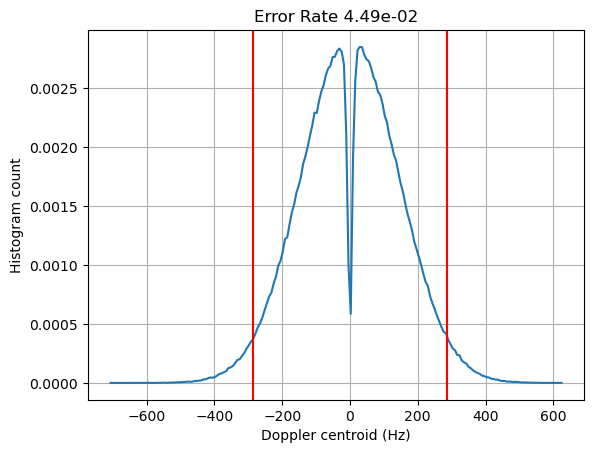

Percent of Swaths in violation: 4.7756


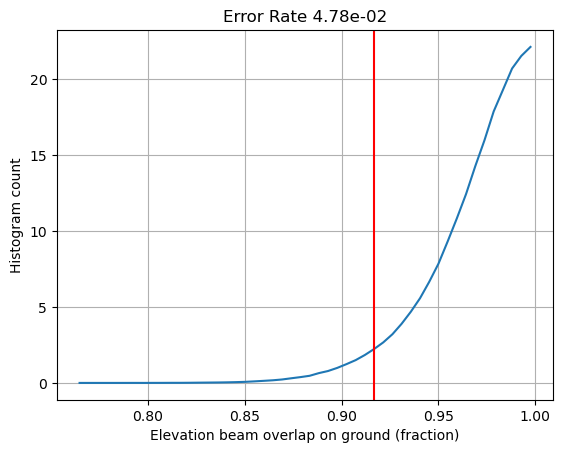

In [7]:
X = mysvs[np.random.randint(0,len(mysvs))]
""" Define the covariances for Thales Alenia Space data """  
covariancesESOCTwoDay = {
    "description": "Covariance matrix errors for TAS consortium",
    "spacecraft": {
        "description": """Errors in the orienting the spacecraft. 
                          These in include star-tracker error, TED, actuator error, 
                          e.t.c.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([1.95e-3, 0.91e-3, 1.22e-3])/2)**2 + #TAS
              (np.diag([11.5e-3, 0.7e-3, 0.7e-3])/2)**2).tolist(), #TAS margin
        },
    "instrument": {
        "description": """Errors marked as TED. 
                          These are assumed to arise from instrument TEDs. 
                          It is assumed there are no other instrument errors.
                          These values from !RequirementSummary of
                          VenSAR_Pointing_Requirements_Table_v5.0.xlsx
                          Note that these come from a pointing requirement and
                          not from CBEs. The CBEs are about 10 percent lower.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([2.39e-3, 0.72e-3, 0.85e-3])/2)**2).tolist()
        },
    "orbitVelocity": {
        "description": """Errors in the orbit velocity vector. Although ESOC
                          covariance analysis includes a velocity error, these
                          are highly correlated with position error. Only a small
                          component of the velocity error that lies out-of-plane
                          survives and is included here.
                          Data from:
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx
                          The following is left over from computing the TCNerrorlpy
                          script and subtracting from ESOC values""",
        "referenceVariables": "VtVcVn",
        "units": "m/s",
        "R": ((np.diag([0.3, 0.9, 0.0001])/3)**2).tolist()
        },
    "orbitAlongTrack": {
        "description": """Error in the orbit time (error in orbit angle).
                          These values from the orbit prediction covariance
                          analysis performed by ESOC. 
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.xlsx""",
        "referenceVariables": "t",
        "units": "s",
        "R": (12161/3)**2/np.linalg.norm(X[3:])**2
        },
    "orbitAcrossTrack": {
        "description": """Error in the orbit across track position (orbit tube c and n)
                          Data from covariance analysis performed by ESOC
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx""",
        "referenceVariables": "dX",
        "units": "m",
        "R": (np.diag([(847/3)**2, (153/3)**2])).tolist()
        }
    }

res = eSim.simulateError(X, 
                         off_nadir, 
                         covariancesESOCTwoDay,
                         dopErrThreshold = 1/9,
                         eleErrThreshold = 1/12,
                         loglevel=3)

Norm of u: 1.000000
u*e1: -0.000000
u*e2: 0.947141, v: 0.947210
uP*VP: 0.000000
Roll: 4.4188, Pitch: -0.0011, Yaw: -0.0136
Percent of Doppler centroids in violation: 4.8889


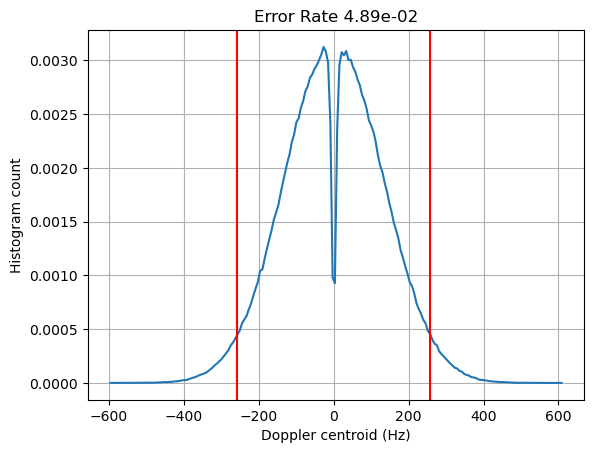

Percent of Swaths in violation: 4.8577


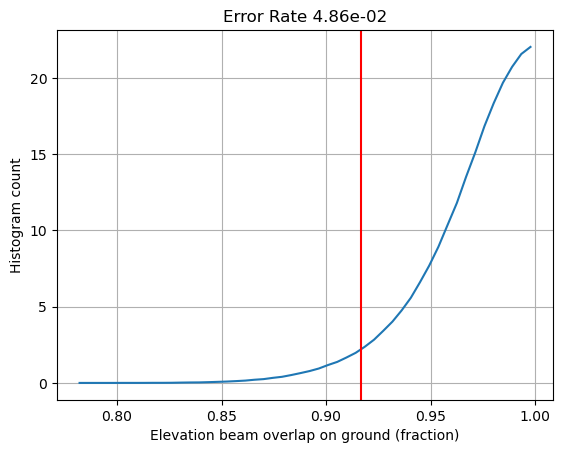

In [8]:
""" Define the covariances with ADS spacecraft data and 1/10 bemawidth for azimuth """  
covariancesESOCTwoDay = {
    "description": "Covariance matrix errors for ADS consortium",
    "spacecraft": {
        "description": """Errors in the orienting the spacecraft. 
                          These in include star-tracker error, TED, actuator error, 
                          e.t.c.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([4.29e-3, 0.83e-3, 0.95e-3])/2)**2 + #ADS
              (np.diag([11.0e-3, 0.3e-3, 0.3e-3])/2)**2).tolist(), #ADS margin
        },
    "instrument": {
        "description": """Errors marked as TED. 
                          These are assumed to arise from instrument TEDs. 
                          It is assumed there are no other instrument errors.
                          These values from !RequirementSummary of
                          VenSAR_Pointing_Requirements_Table_v5.0.xlsx
                          Note that these come from a pointing requirement and
                          not from CBEs. The CBEs are about 10 percent lower.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([2.39e-3, 0.72e-3, 0.85e-3])/2)**2).tolist()
        },
    "orbitVelocity": {
        "description": """Errors in the orbit velocity vector. Although ESOC
                          covariance analysis includes a velocity error, these
                          are highly correlated with position error. Only a small
                          component of the velocity error that lies out-of-plane
                          survives and is included here.
                          Data from:
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx
                          The following is left over from computing the TCNerrorlpy
                          script and subtracting from ESOC values""",
        "referenceVariables": "VtVcVn",
        "units": "m/s",
        "R": ((np.diag([0.3, 0.9, 0.0001])/3)**2).tolist()
        },
    "orbitAlongTrack": {
        "description": """Error in the orbit time (error in orbit angle).
                          These values from the orbit prediction covariance
                          analysis performed by ESOC. 
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.xlsx""",
        "referenceVariables": "t",
        "units": "s",
        "R": (12161/3)**2/np.linalg.norm(X[3:])**2
        },
    "orbitAcrossTrack": {
        "description": """Error in the orbit across track position (orbit tube c and n)
                          Data from covariance analysis performed by ESOC
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx""",
        "referenceVariables": "dX",
        "units": "m",
        "R": (np.diag([(847/3)**2, (153/3)**2])).tolist()
        }
    }

res = eSim.simulateError(X, 
                         off_nadir, 
                         covariancesESOCTwoDay,
                         dopErrThreshold = 1/10,
                         eleErrThreshold = 1/12,
                         loglevel=3)

Norm of u: 1.000000
u*e1: -0.000000
u*e2: 0.947141, v: 0.947210
uP*VP: 0.000000
Roll: 4.4188, Pitch: -0.0011, Yaw: -0.0136
Percent of Doppler centroids in violation: 4.9062


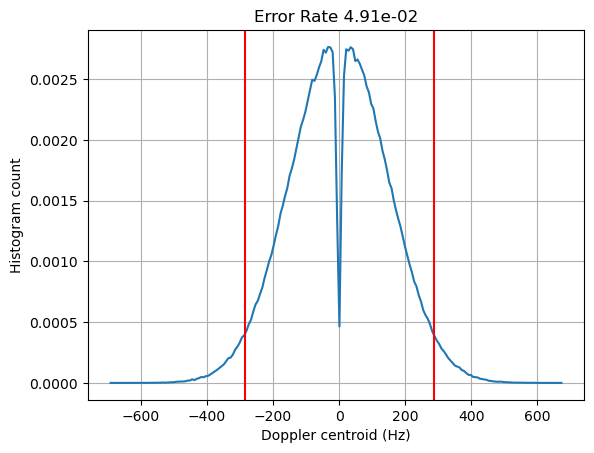

Percent of Swaths in violation: 4.9672


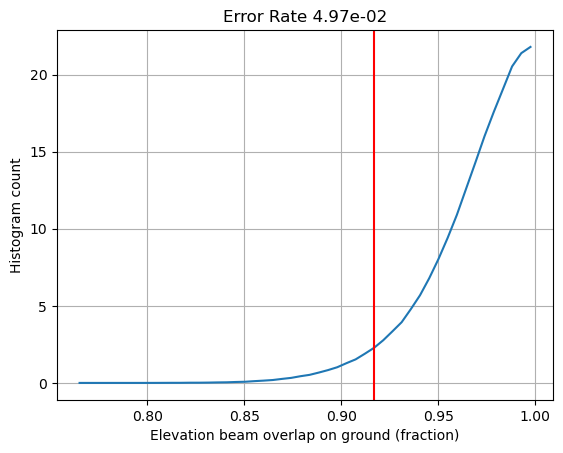

In [9]:
""" Define the covariances with ADS spacecraft data and 1/9 bemawidth for azimuth """  
covariancesESOCTwoDay = {
    "description": "Covariance matrix errors for ADS consortium",
    "spacecraft": {
        "description": """Errors in the orienting the spacecraft. 
                          These in include star-tracker error, TED, actuator error, 
                          e.t.c.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([4.29e-3, 0.83e-3, 0.95e-3])/2)**2 + #ADS
              (np.diag([11.0e-3, 0.9e-3, 0.9e-3])/2)**2).tolist(), #ADS margin
        },
    "instrument": {
        "description": """Errors marked as TED. 
                          These are assumed to arise from instrument TEDs. 
                          It is assumed there are no other instrument errors.
                          These values from !RequirementSummary of
                          VenSAR_Pointing_Requirements_Table_v5.0.xlsx
                          Note that these come from a pointing requirement and
                          not from CBEs. The CBEs are about 10 percent lower.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([2.39e-3, 0.72e-3, 0.85e-3])/2)**2).tolist()
        },
    "orbitVelocity": {
        "description": """Errors in the orbit velocity vector. Although ESOC
                          covariance analysis includes a velocity error, these
                          are highly correlated with position error. Only a small
                          component of the velocity error that lies out-of-plane
                          survives and is included here.
                          Data from:
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx
                          The following is left over from computing the TCNerrorlpy
                          script and subtracting from ESOC values""",
        "referenceVariables": "VtVcVn",
        "units": "m/s",
        "R": ((np.diag([0.3, 0.9, 0.0001])/3)**2).tolist()
        },
    "orbitAlongTrack": {
        "description": """Error in the orbit time (error in orbit angle).
                          These values from the orbit prediction covariance
                          analysis performed by ESOC. 
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.xlsx""",
        "referenceVariables": "t",
        "units": "s",
        "R": (12161/3)**2/np.linalg.norm(X[3:])**2
        },
    "orbitAcrossTrack": {
        "description": """Error in the orbit across track position (orbit tube c and n)
                          Data from covariance analysis performed by ESOC
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx""",
        "referenceVariables": "dX",
        "units": "m",
        "R": (np.diag([(847/3)**2, (153/3)**2])).tolist()
        }
    }

res = eSim.simulateError(X, 
                         off_nadir, 
                         covariancesESOCTwoDay,
                         dopErrThreshold = 1/9,
                         eleErrThreshold = 1/12,
                         loglevel=3)

In [16]:
""" RPY 2-sigma values from T error ESOC """
R_AEUt = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[3:6,3:6]
print(R_AEUt)
R_RPYt = eSim.aeu2rpyCovariance(R_AEUt)
print(R_RPYt)
print(np.diag(R_RPYt))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYt))*1e3*2)

[[ 3.97015947e-07 -9.37721333e-11 -6.61402733e-09]
 [-9.37721333e-11  2.21806876e-14  1.56218366e-12]
 [-6.61402733e-09  1.56218366e-12  1.10185392e-10]]
[[ 2.89992751e-14 -9.10657850e-11 -2.15699770e-11]
 [-9.10657850e-11  3.74977530e-07  8.88177385e-08]
 [-2.15699770e-11  8.88177385e-08  2.10375024e-08]]
[2.89992751e-14 3.74977530e-07 2.10375024e-08]
2-sigma values (Roll, Pitch, Yaw)
[3.40583470e-04 1.22470818e+00 2.90086210e-01]


In [17]:
""" RPY 2-sigma values from velocity errors ESOC """
R_AEUv = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[6:9,6:9]
print(R_AEUv)
R_RPYv = eSim.aeu2rpyCovariance(R_AEUv)
print(R_RPYv)
print(np.diag(R_RPYv))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYv))*1e3*2)

[[ 4.90209915e-13 -3.78295192e-13  2.96418005e-11]
 [-3.78295192e-13  2.91943349e-13 -2.28755927e-11]
 [ 2.96418005e-11 -2.28755927e-11  1.79244619e-09]]
[[ 2.91338676e-13  5.26494118e-12 -2.22158965e-11]
 [ 5.26494118e-12  9.51457099e-11 -4.01475853e-10]
 [-2.22158965e-11 -4.01475853e-10  1.69406376e-09]]
[2.91338676e-13 9.51457099e-11 1.69406376e-09]
2-sigma values (Roll, Pitch, Yaw)
[0.00107952 0.01950853 0.08231801]


In [19]:
""" RPY 2-sigma values from across-track and radial errors ESOC """
R_AEUp = np.array([[0,0,0],
                  [0,res["computed"]["ErrorCovariance"]["BlockCovariance"][9][9],0],
                  [0,0,0]])
print(R_AEUp)
R_RPYp = eSim.aeu2rpyCovariance(R_AEUp)
print(R_RPYp)
print(np.diag(R_RPYp))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYp))*1e3*2)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.41578909e-07 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[1.40973368e-07 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[1.40973368e-07 0.00000000e+00 0.00000000e+00]
2-sigma values (Roll, Pitch, Yaw)
[0.75092841 0.         0.        ]


In [20]:
""" RPY 2-sigma values from instrument JPL """
R_AEUi = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[10:13,10:13]
print(R_AEUi)
R_RPYi = eSim.aeu2rpyCovariance(R_AEUi)
print(R_RPYi)
print(np.diag(R_RPYi))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYi))*1e3*2)

[[ 1.32797581e-07 -6.78490119e-10  1.11822821e-08]
 [-6.78490119e-10  1.43224935e-06 -3.11908972e-10]
 [ 1.11822821e-08 -3.11908972e-10  1.78425409e-07]]
[[ 1.43194210e-06 -3.20744523e-09  1.36023772e-10]
 [-3.20744523e-09  1.30802141e-07 -1.56906091e-09]
 [ 1.36023772e-10 -1.56906091e-09  1.83463395e-07]]
[1.43194210e-06 1.30802141e-07 1.83463395e-07]
2-sigma values (Roll, Pitch, Yaw)
[2.39327567 0.72333157 0.85665254]


In [21]:
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYt+R_RPYv+R_RPYp))*1e3*2)

2-sigma values (Roll, Pitch, Yaw)
[0.75092926 1.22486354 0.30153982]


In [23]:
print("2-sigma values (Azimuth, Elevation, Tilt)")
print(np.sqrt(np.diag(R_AEUt+R_AEUv+R_AEUp))*1e3*2)

2-sigma values (Azimuth, Elevation, Tilt)
[1.26018481 0.75254029 0.08723833]


In [15]:
print(json.dumps(res, indent=2))

{
  "given": {
    "off_nadir": 18.7,
    "azAxis": 5.5,
    "elAxis": 0.6125,
    "carrier": 3150000000.0,
    "covariances": {
      "description": "Covariance matrix errors for ADS consortium",
      "spacecraft": {
        "description": "Errors in the orienting the spacecraft. \n                          These in include star-tracker error, TED, actuator error, \n                          e.t.c.",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": [
          [
            3.4851025e-05,
            0.0,
            0.0
          ],
          [
            0.0,
            3.74725e-07,
            0.0
          ],
          [
            0.0,
            0.0,
            4.2812500000000003e-07
          ]
        ]
      },
      "instrument": {
        "description": "Errors marked as TED. \n                          These are assumed to arise from instrument TEDs. \n                          It is assumed there are no other instrument errors.\